- Minecraft Version 1.21.5
- Seed: "vcpi"
- Gamerules: "doDaylightCycle=false" "doWeatherCycle=false" "doMobSpawning=false"
- Commands. /time set day
- render distance: 12

In [1]:
import time

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

from src.dataset import PairedImageDataset
from src.plot_utils import show_image_pairs, plot_training_metrics, show_test_results

cuda = torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")
print(f"Using device: {device}")

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Using device: cuda


In [2]:
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

full_dataset = PairedImageDataset("generator_bot/screenshots", transforms=transform)

dataset_size = len(full_dataset)
test_size = int(0.2 * dataset_size)
train_size = dataset_size - test_size

print(f"Total dataset size: {dataset_size}")
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 4

train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4)

print(f"Train batches: {len(train_dl)}")
print(f"Test batches: {len(test_dl)}")

Total dataset size: 3600
Train size: 2880
Test size: 720
Train batches: 720
Test batches: 180


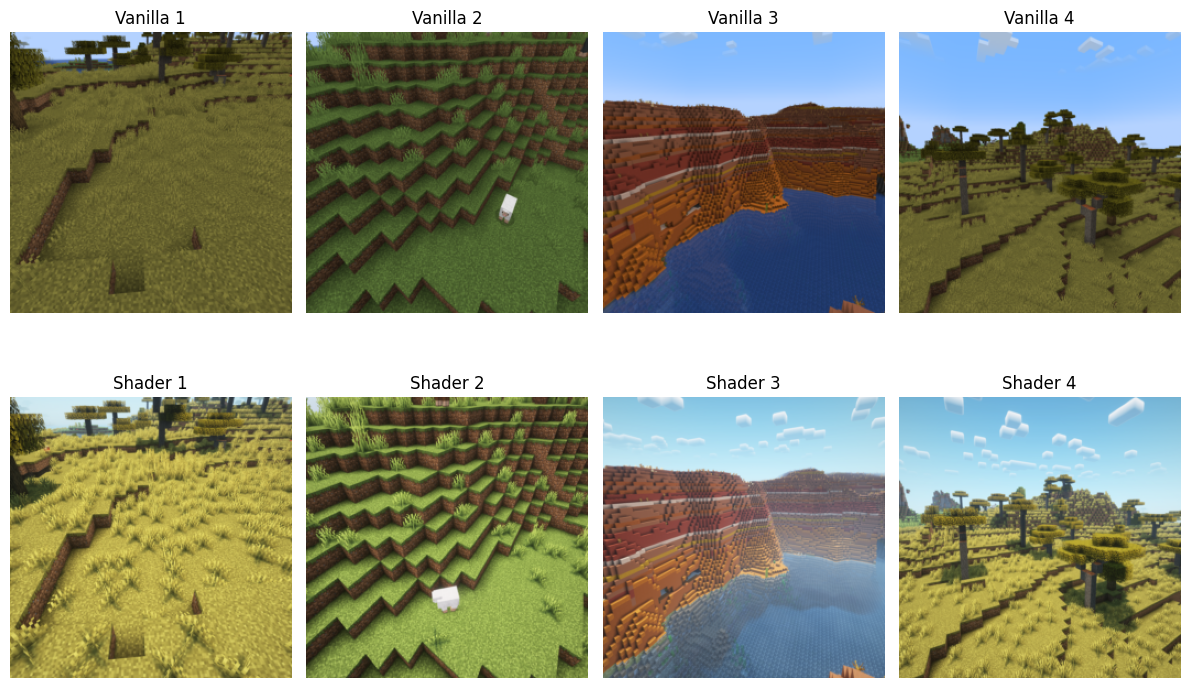

In [3]:
show_image_pairs(train_dl, num_pairs=4)

In [4]:
from src.models import GeneratorUNet, PatchDiscriminator, weights_init_normal

G = GeneratorUNet().to(device)
D = PatchDiscriminator().to(device)

G.apply(weights_init_normal)
D.apply(weights_init_normal)

g_opt = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

gan_criterion = nn.BCEWithLogitsLoss()
l1_criterion = nn.L1Loss()

In [5]:
def train_epoch(dataloader, G, D, g_opt, d_opt, gan_crit, l1_crit, lambda_l1=100):
    G.train()
    D.train()

    total_discriminator_loss = 0
    total_generator_loss = 0
    total_gan_loss = 0
    total_l1_loss = 0
    total_real_loss = 0
    total_fake_loss = 0

    num_batches = 0

    loop = tqdm(dataloader, leave=True, unit_scale=BATCH_SIZE, unit="pairs")

    for idx, batch in enumerate(loop):
        x = batch["vanilla"].to(device, non_blocking=True)
        y = batch["shader"].to(device, non_blocking=True)

        valid = torch.ones((x.size(0), 1, 16, 16), device=device)
        fake = torch.zeros_like(valid)

        # ---- Discriminator ----
        d_opt.zero_grad()
        # Real
        real_pred = D(x, y)
        d_real_loss = gan_crit(real_pred, valid)
        # Fake
        y_fake = G(x)
        fake_pred = D(x, y_fake.detach())
        d_fake_loss = gan_crit(fake_pred, fake)
        d_loss = (d_real_loss + d_fake_loss) * 0.5
        d_loss.backward()
        d_opt.step()

        # ---- Generator ----
        g_opt.zero_grad()
        # GAN loss
        fake_pred = D(x, y_fake)
        g_gan = gan_crit(fake_pred, valid)
        # Reconstruction loss
        g_l1 = l1_crit(y_fake, y) * lambda_l1
        g_loss = g_gan + g_l1
        g_loss.backward()
        g_opt.step()

        total_discriminator_loss += d_loss.item()
        total_generator_loss += g_loss.item()
        total_gan_loss += g_gan.item()
        total_l1_loss += g_l1.item()
        total_real_loss += d_real_loss.item()
        total_fake_loss += d_fake_loss.item()
        num_batches += 1

        loop.set_postfix(
            d_loss=total_discriminator_loss / (idx + 1),
            d_real_loss=total_real_loss / (idx + 1),
            d_fake_loss=total_fake_loss / (idx + 1),
            g_loss=total_generator_loss / (idx + 1),
            g_gan=total_gan_loss / (idx + 1),
            g_l1=total_l1_loss / (idx + 1),
        )

    return {
        "discriminator_loss": total_discriminator_loss / num_batches,
        "generator_loss": total_generator_loss / num_batches,
        "gan_loss": total_gan_loss / num_batches,
        "l1_loss": total_l1_loss / num_batches,
        "real_loss": total_real_loss / num_batches,
        "fake_loss": total_fake_loss / num_batches,
    }

In [6]:
def evaluate_model(dataloader, G, D, gan_crit, l1_crit, lambda_l1=100):
    """Evaluate the model on test data"""
    G.eval()
    D.eval()
    
    total_generator_loss = 0
    total_discriminator_loss = 0
    total_gan_loss = 0
    total_l1_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            x = batch["vanilla"].to(device, non_blocking=True)
            y = batch["shader"].to(device, non_blocking=True)
            
            valid = torch.ones((x.size(0), 1, 16, 16), device=device)
            fake = torch.zeros_like(valid)
            
            # Generate fake images
            y_fake = G(x)
            
            # Discriminator loss
            real_pred = D(x, y)
            fake_pred = D(x, y_fake)
            d_real_loss = gan_crit(real_pred, valid)
            d_fake_loss = gan_crit(fake_pred, fake)
            d_loss = (d_real_loss + d_fake_loss) * 0.5
            
            # Generator loss
            fake_pred = D(x, y_fake)
            g_gan = gan_crit(fake_pred, valid)
            g_l1 = l1_crit(y_fake, y) * lambda_l1
            g_loss = g_gan + g_l1
            
            total_generator_loss += g_loss.item()
            total_discriminator_loss += d_loss.item()
            total_gan_loss += g_gan.item()
            total_l1_loss += g_l1.item()
            num_batches += 1
    
    return {
        "test_generator_loss": total_generator_loss / num_batches,
        "test_discriminator_loss": total_discriminator_loss / num_batches,
        "test_gan_loss": total_gan_loss / num_batches,
        "test_l1_loss": total_l1_loss / num_batches,
    }


In [7]:
from src.checkpoint_utils import save_checkpoint, load_checkpoint

prev_time = time.time()

EPOCHS = 100
CHECKPOINT_FREQUENCY = 10  # Save checkpoint every 10 epochs
LOAD_CHECKPOINT = 100  # Set to epoch number to load specific checkpoint, or None to start fresh

# Load checkpoint or start fresh
checkpoint_dir = "checkpoints"
if LOAD_CHECKPOINT is not None:
    start_epoch, train_metrics, test_metrics = load_checkpoint(LOAD_CHECKPOINT, G, D, g_opt, d_opt, device)
else:
    print("Starting training from scratch.")
    start_epoch, train_metrics, test_metrics = 0, [], []

for epoch in range(start_epoch, EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 50)

    # Train
    train_results = train_epoch(train_dl, G, D, g_opt, d_opt, gan_criterion, l1_criterion)
    train_metrics.append(train_results)

    # Evaluate on test set
    test_results = evaluate_model(test_dl, G, D, gan_criterion, l1_criterion)
    test_metrics.append(test_results)

    # Print results
    print(f"Train - G Loss: {train_results['generator_loss']:.4f}, D Loss: {train_results['discriminator_loss']:.4f}")
    print(f"Test  - G Loss: {test_results['test_generator_loss']:.4f}, D Loss: {test_results['test_discriminator_loss']:.4f}")

    current_time = time.time()
    elapsed = current_time - prev_time
    print(f"Time elapsed: {elapsed:.2f}s")
    prev_time = current_time

    if (epoch + 1) % CHECKPOINT_FREQUENCY == 0:
        save_checkpoint(epoch, G, D, g_opt, d_opt, train_metrics, test_metrics)
    elif epoch == EPOCHS - 1:
        save_checkpoint(epoch, G, D, g_opt, d_opt, train_metrics, test_metrics)

Loading checkpoint: checkpoints\checkpoint_epoch_100.pth
Checkpoint loaded. Resuming from epoch 100


Results on Test Set:


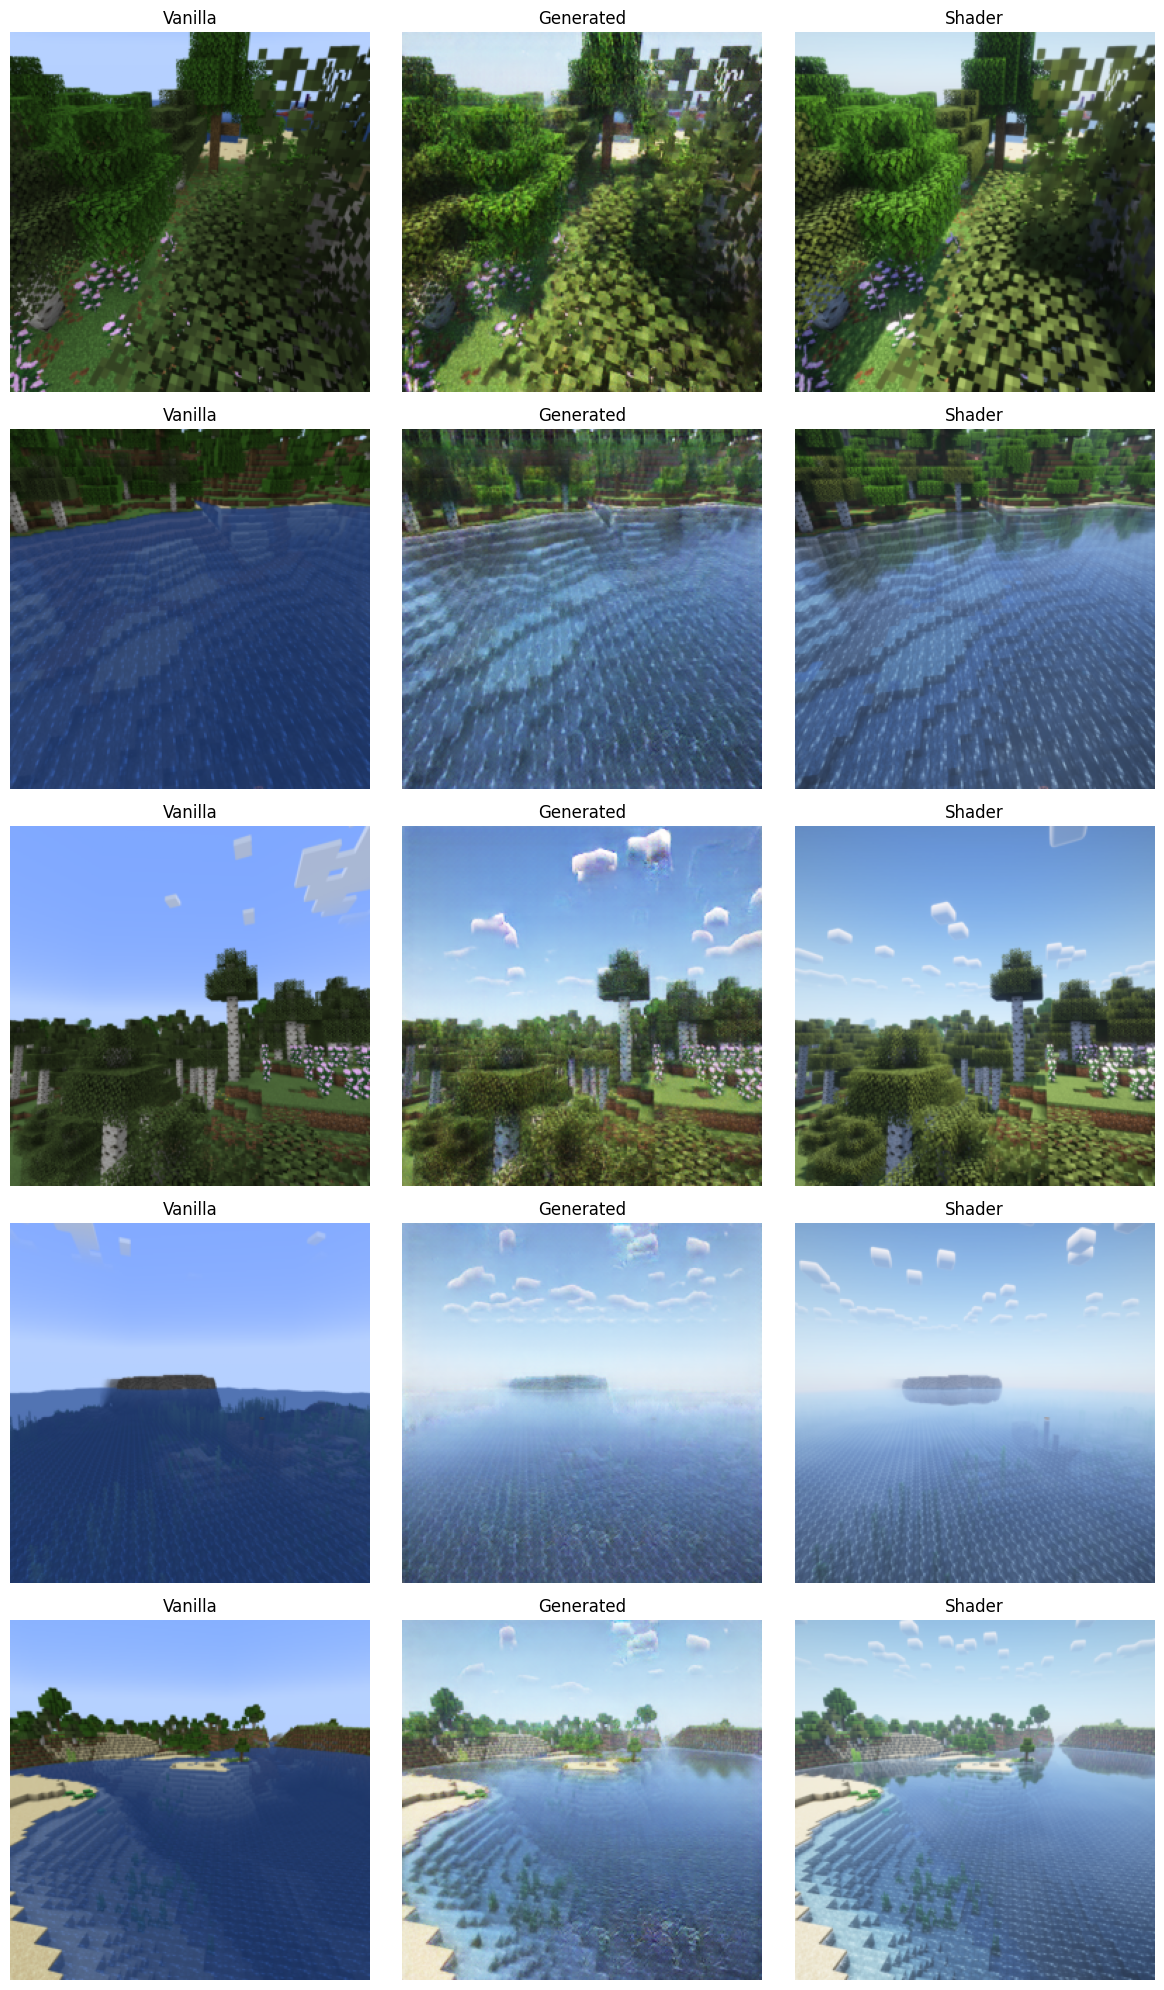

In [8]:
# Show results on test set
show_test_results(G, test_dl, device, num_samples=5)

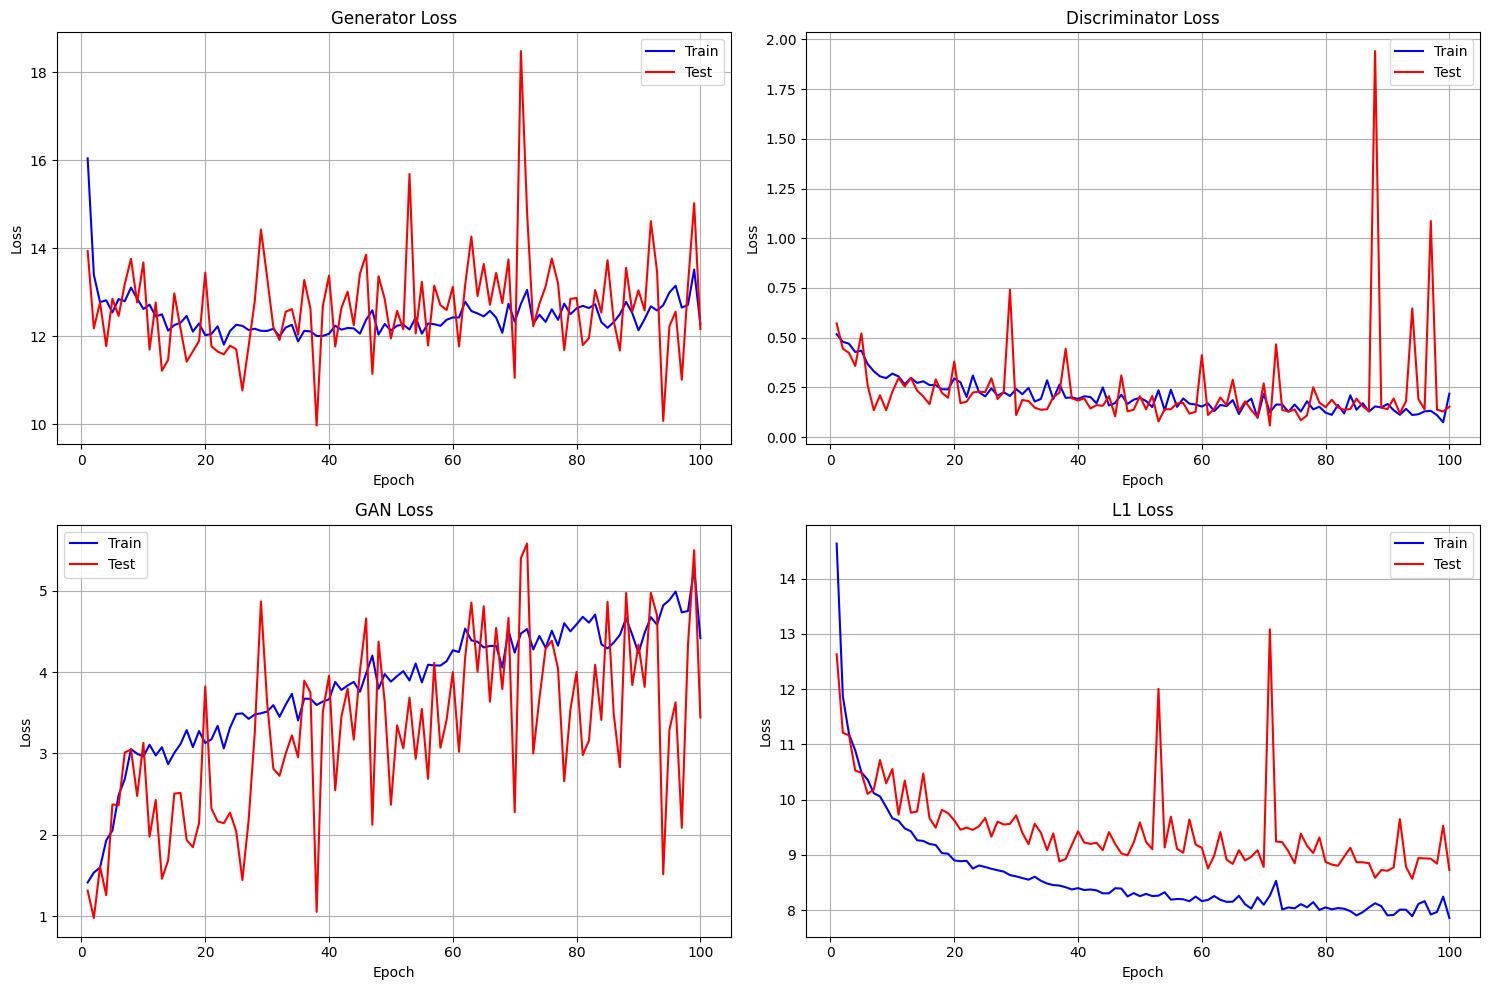


Final Metrics:
Train Generator Loss: 12.2751
Test Generator Loss: 12.1690
Train Discriminator Loss: 0.2182
Test Discriminator Loss: 0.1527


In [9]:
# Plot training and test metrics
plot_training_metrics(train_metrics, test_metrics)

# Print final metrics
print("\nFinal Metrics:")
print(f"Train Generator Loss: {train_metrics[-1]['generator_loss']:.4f}")
print(f"Test Generator Loss: {test_metrics[-1]['test_generator_loss']:.4f}")
print(f"Train Discriminator Loss: {train_metrics[-1]['discriminator_loss']:.4f}")
print(f"Test Discriminator Loss: {test_metrics[-1]['test_discriminator_loss']:.4f}")

In [10]:
# Evaluate comprehensive image quality metrics (PSNR, SSIM, FID, LPIPS)
from src.evaluation_metrics import evaluate_generator_metrics, print_metrics_summary

test_metrics = evaluate_generator_metrics(G, test_dl, device)
print_metrics_summary(test_metrics)

Computing image quality metrics...


Evaluating metrics: 100%|██████████| 180/180 [00:17<00:00, 10.21it/s]


PSNR (higher is better):  23.0358 ± 1.5317 dB
SSIM (higher is better):  0.7719 ± 0.0437
FID (lower is better):    54.5093
LPIPS (lower is better):  0.1840 ± 0.0324
